In [1]:
#!pip install PeakDetective
import PeakDetective
import PeakDetective.detection_helper as detection_helper
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import pickle as pkl
import os
import shutil

#model parameters, not recomended to change
resolution = 60 #number of data point in 1 min EIC
window = 1.0 #size of EIC window (in minutes)
min_peaks = 100000 #minimum number of peaks used to train autoencoder
smooth_epochs = 10 #number of smoothing epochs to use
batchSizeSmoother = 64 #batch size for training smoother
validationSplitSmoother = 0.1 #fraction of data used for validation split when training smoother
minClassifierTrainEpochs = 200 #minimum number of epochs for training classifier
maxClassifierTrainEpochs = 1000 #maximum number of epochs for training classifier
classifierBatchSize = 4 #batch size for training classifier
randomRestarts = 1 #number of random restarts to use when training classifier
numValPeaks = 10 #number of validaiton peaks for user to label
numPeaksPerRound = 10 #number of peaks to label per active learning iteration
numCores = 10 #number of processor cores to use
numDataPoints = 3 #number of consequetive scans above noise to count as ROI

In [2]:
mzMLDir = "X:/LLFS/Polars/negative_mode_mzmls/"
reference = "BatchD_nP_QC_06.mzML"

In [3]:
peakFile = mzMLDir + "for_training/peaks.csv" #path to peak file

In [4]:
trainingMzMLFolder = mzMLDir + "for_training/" #path to raw data folder

In [5]:
ms1ppm = 25.5 #ppm tolerance
peakWidth = (13.8,114.6) #retentin time peak width range (in seconds)
s2n = 13.6 #signal to noise cutoff
noise = 100 #noise threshold
mzDiff = 0.0144 #minimum meaningful m/z difference
prefilter = 5 #number of required consecutive scans to consider for ROI detection

In [ ]:
det = detection_helper.PeakList()
det.runXCMS(trainingMzMLFolder , peakFile.split("/")[-1], "negative", ms1ppm, peakWidth,s2n=s2n,noise=noise,mzDiff=mzDiff,prefilter=prefilter)

In [6]:
det = detection_helper.PeakList()
det.readXCMSPeakList(trainingMzMLFolder+"peaks.csv")
peaklist = det.peakList[["mz","rt"]]
peaklist

,mz,rt
FT00001,51.025134,6.230604
FT00002,51.025133,5.922523
FT00003,52.980492,5.090126
FT00004,52.980477,4.510849
FT00005,52.980474,4.617508
...,...,...
FT12653,998.015054,1.464955
FT12654,998.098053,6.748917
FT12655,998.462823,0.863184
FT12656,998.626227,1.076381


In [7]:
#load raw data
raw_data = []
for file in [x for x in os.listdir(trainingMzMLFolder) if ".mzML" in x]:
    temp = PeakDetective.rawData()
    temp.readRawDataFile(trainingMzMLFolder + "/" + file,ms1ppm)
    raw_data.append(temp)

In [8]:
integ = PeakDetective.PeakDetective(numCores = numCores,resolution=resolution)

In [9]:
if __name__ == "__main__":
    X = integ.makeDataMatrix(raw_data,peaklist["mz"],peaklist["rt"].values,align=True)

forming matrix |██████████████████████████████████████████████████| 100.0% 
aligning EICs |██████████████████████████████████████████████████| 100.0% 


In [10]:
if __name__ == "__main__":
    integ.trainSmoother(peaklist,raw_data,min_peaks,smooth_epochs,batchSizeSmoother,validationSplitSmoother)

generating EICs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
done
fitting smoother...
Epoch 1/10
1407/1407 [==============================] - 33s 22ms/step - loss: 0.1638 - mean_absolute_error: 0.0869 - val_loss: 0.0840 - val_mean_absolute_error: 0.0209
Epoch 2/10
1407/1407 [==============================] - 29s 21ms/step - loss: 0.0774 - mean_absolute_error: 0.0184 - val_loss: 0.0725 - val_mean_absolute_error: 0.0159
Epoch 3/10
1407/1407 [==============================] - 29s 21ms/step - loss: 0.0716 - mean_absolute_error: 0.0151 - val_loss: 0.0708 - val_mean_absolute_error: 0.0144
Epoch 4/10
1407/1407 [==============================] - 28s 20ms/step - loss: 0.0703 - mean_absolute_error: 0.0142 - val_loss: 0.0698 - val_mean_absolute_error: 0.0139
Epoch 5/10
1407/1407 [==============================] - 30s 21ms/step - loss: 0.0692 - mean_absolute_error: 0.0135 - val_loss: 0.0684 - val_mean_absolute_error: 0.0130
Epoch 6/10
1407/1407 [==================

1/1 [==============================] - 0s 39ms/step
loss: 0.26538148522377014 mean_absolute_error: 0.12614531815052032 val loss: 0.41019558906555176 val_mean_absolute_error: 0.22757141292095184 numEpochs: 200
1575/1575 [==============================] - 2s 1ms/step


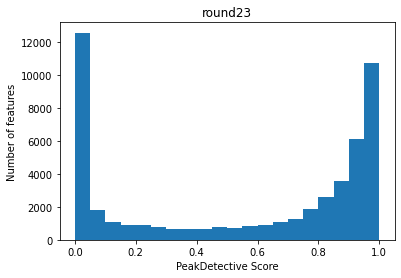

50388 unclassified features remaining
Continue with another iteration? (1=Yes, 0=No): 


 0


1/1 [==============================] - 0s 21ms/step


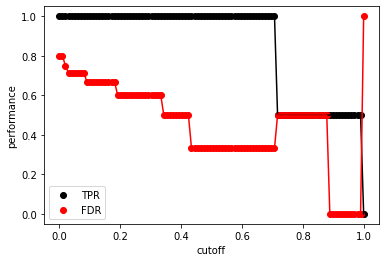

In [11]:
if __name__ == "__main__":
    #train classifier
    integ.trainClassifierActive(X,[],[],minClassifierTrainEpochs,maxClassifierTrainEpochs,classifierBatchSize,randomRestarts,numVal = numValPeaks,numManualPerRound=numPeaksPerRound,inJupyter=True)

In [7]:
cutoff = 0.8

In [13]:
integ.save(mzMLDir+"PeakDetectiveObject/")

In [8]:
integ = PeakDetective.PeakDetective(numCores = numCores,resolution=resolution)
integ.load(mzMLDir+"PeakDetectiveObject/")

In [9]:
detectionMzMLFolder = mzMLDir + "for_detection/" #path to raw data folder

In [23]:
detectFrac = 0.5 #fraction of samples were a feature must be detected
noise = 10000 #noise threshold for finding ROIs (set to baseline noise value)
ms1ppm = 25.5 #ppm tolerance
align = True #whether to perform RT alignment
window = 0.1 #minimum expected spacing between peaks in minutes. Generally 0.05 to 0.2 works well.

In [20]:
if __name__ == "__main__":
    raw_data = []
    for file in [reference] + [x for x in os.listdir(detectionMzMLFolder) if ".mzML" in x and x != reference]:
        temp = PeakDetective.rawData()
        temp.readRawDataFile(detectionMzMLFolder + "/" + file,ms1ppm)
        raw_data.append(temp)

In [23]:
if __name__ == "__main__":
    peak_scores_pd_det, peak_intensities_pd_det,rois = integ.detectPeaks(raw_data, cutoff=cutoff, intensityCutoff = noise,numDataPoints=numDataPoints,window=window,align=align,detectFrac=detectFrac)

Detecting ROIs |█████████████████████████████████████████████████-| 100.0% 3191 ROIs found
3140  ROIs found
generating all EICs from ROIs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
aligning EICs |██████████████████████████████████████████████████| 100.0% 
6908000 EICs constructed for evaluation
12053/12053 [==============================] - 14s 1ms/step
done
refining retention times |██████████████████████████████████████████████████| 100.0% 
refining mzs |██████████████████████████████████████████████████| 100.0% 
integrating peaks...
integrating peaks |██████████████████████████████████████████████████| 100.0% 
3882  peaks found


In [26]:
peak_intensities_pd_det.to_csv(mzMLDir + "peaks_pd.csv")

In [12]:
peak_intensities_pd_det = pd.read_csv(mzMLDir + "peaks_pd.csv",index_col=0)

In [13]:
peak_intensities_pd_det

,mz,rt,X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_QC_06.mzML,X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_Blank_2.mzML,X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_Blank_3.mzML,X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_Blank_4.mzML,X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_QC_03.mzML,X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_QC_04.mzML,X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_QC_05.mzML,X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_QC_07.mzML,X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_QC_08.mzML,X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_QC_09.mzML
0,57.034507,1.93,138755.983519,20263.998745,19249.262345,22973.055391,134089.824969,144439.477708,128888.786755,141129.267270,137428.269153,148876.861299
1,57.035026,5.45,55942.915708,4687.426337,2696.594042,20893.237997,48320.051942,45902.199517,44782.369834,51446.495757,39188.608491,61164.612459
2,57.034912,6.61,43354.808536,4432.320988,3592.621762,4041.978834,38973.572120,51789.122732,43961.957495,46970.107571,74907.502120,48377.616335
3,57.034954,6.61,36303.333687,3868.459865,2831.591235,3264.675212,29262.366824,39607.029338,36408.646282,35576.080867,56936.485993,39959.207352
4,57.034526,1.93,157188.729479,32884.843264,25982.134210,27489.777752,156507.152646,171911.450556,162789.706711,157883.774931,158847.888088,158936.284385
...,...,...,...,...,...,...,...,...,...,...,...,...
5298,993.291293,7.51,90877.221910,203329.269169,170807.649777,180954.988050,99177.299350,101412.861624,99401.855038,90905.214230,93700.971820,86331.627816
5299,993.597406,0.83,78875.028809,183953.303003,197553.505590,156567.813891,79374.744088,74381.607939,75877.510163,77902.738036,77475.450469,75321.974772
5301,994.602444,0.85,42313.745454,99577.321185,103649.367515,84909.466335,40715.160548,37238.336439,35390.932632,37167.847473,41212.372595,44524.412270
5303,997.460623,0.86,209781.108504,2573.493432,1151.754236,2100.730449,215947.948013,205392.013543,208459.798959,202569.068533,198215.093453,197591.001265


In [14]:
det = detection_helper.PeakList()
det.from_df(peak_intensities_pd_det)
print(det.sampleCols)
det.peakList

['X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_QC_06.mzML', 'X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_Blank_2.mzML', 'X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_Blank_3.mzML', 'X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_Blank_4.mzML', 'X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_QC_03.mzML', 'X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_QC_04.mzML', 'X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_QC_05.mzML', 'X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_QC_07.mzML', 'X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_QC_08.mzML', 'X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_QC_09.mzML']


,mz,rt,X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_QC_06.mzML,X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_Blank_2.mzML,X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_Blank_3.mzML,X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_Blank_4.mzML,X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_QC_03.mzML,X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_QC_04.mzML,X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_QC_05.mzML,X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_QC_07.mzML,X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_QC_08.mzML,X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_QC_09.mzML
0,57.034507,1.93,138755.983519,20263.998745,19249.262345,22973.055391,134089.824969,144439.477708,128888.786755,141129.267270,137428.269153,148876.861299
1,57.035026,5.45,55942.915708,4687.426337,2696.594042,20893.237997,48320.051942,45902.199517,44782.369834,51446.495757,39188.608491,61164.612459
2,57.034912,6.61,43354.808536,4432.320988,3592.621762,4041.978834,38973.572120,51789.122732,43961.957495,46970.107571,74907.502120,48377.616335
3,57.034954,6.61,36303.333687,3868.459865,2831.591235,3264.675212,29262.366824,39607.029338,36408.646282,35576.080867,56936.485993,39959.207352
4,57.034526,1.93,157188.729479,32884.843264,25982.134210,27489.777752,156507.152646,171911.450556,162789.706711,157883.774931,158847.888088,158936.284385
...,...,...,...,...,...,...,...,...,...,...,...,...
5298,993.291293,7.51,90877.221910,203329.269169,170807.649777,180954.988050,99177.299350,101412.861624,99401.855038,90905.214230,93700.971820,86331.627816
5299,993.597406,0.83,78875.028809,183953.303003,197553.505590,156567.813891,79374.744088,74381.607939,75877.510163,77902.738036,77475.450469,75321.974772
5301,994.602444,0.85,42313.745454,99577.321185,103649.367515,84909.466335,40715.160548,37238.336439,35390.932632,37167.847473,41212.372595,44524.412270
5303,997.460623,0.86,209781.108504,2573.493432,1151.754236,2100.730449,215947.948013,205392.013543,208459.798959,202569.068533,198215.093453,197591.001265


In [15]:
det.backgroundSubtract(["lank"],["QC"],3)
det.peakList

1264 background features found


,mz,rt,X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_QC_06.mzML,X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_Blank_2.mzML,X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_Blank_3.mzML,X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_Blank_4.mzML,X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_QC_03.mzML,X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_QC_04.mzML,X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_QC_05.mzML,X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_QC_07.mzML,X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_QC_08.mzML,X:/LLFS/Polars/negative_mode_mzmls/for_detection//BatchD_nP_QC_09.mzML
0,57.034507,1.93,138755.983519,20263.998745,19249.262345,22973.055391,134089.824969,144439.477708,128888.786755,141129.267270,137428.269153,148876.861299
1,57.035026,5.45,55942.915708,4687.426337,2696.594042,20893.237997,48320.051942,45902.199517,44782.369834,51446.495757,39188.608491,61164.612459
2,57.034912,6.61,43354.808536,4432.320988,3592.621762,4041.978834,38973.572120,51789.122732,43961.957495,46970.107571,74907.502120,48377.616335
3,57.034954,6.61,36303.333687,3868.459865,2831.591235,3264.675212,29262.366824,39607.029338,36408.646282,35576.080867,56936.485993,39959.207352
4,57.034526,1.93,157188.729479,32884.843264,25982.134210,27489.777752,156507.152646,171911.450556,162789.706711,157883.774931,158847.888088,158936.284385
...,...,...,...,...,...,...,...,...,...,...,...,...
5292,991.109368,6.78,246320.380128,3099.131299,2404.626076,1729.465128,240846.096045,231892.311283,244334.586436,240868.003250,255317.125796,245386.185682
5294,992.108707,6.76,77867.811464,3487.759771,1003.311548,2461.513561,75808.024378,74336.538425,75785.613467,77452.606185,81010.452280,80379.634502
5296,993.099716,6.76,142847.305501,2468.719850,3984.295291,1101.976966,135131.803579,132828.044633,137809.749626,144549.147708,134005.408357,141791.440215
5303,997.460623,0.86,209781.108504,2573.493432,1151.754236,2100.730449,215947.948013,205392.013543,208459.798959,202569.068533,198215.093453,197591.001265


In [29]:
metadata = pd.read_csv(mzMLDir + "LLFS_Experiment_parameters_v9.csv")
metadata

,Unnamed: 0,peak area sample name,Unnamed: 0.1,File name lipids pos,File name lipids neg,File name metabolites pos,File name metabolites neg,Batch analysis,Batch list,Batch list #,...,collectdate,drawtime,receivedate,receivetime,interval_hrs,spouse_controls,Acq times for File name metabolites neg,found matching File name metabolites neg,Acq times for File name metabolites pos,found matching File name metabolites pos
0,0,Batch11_QC_01,6,BatchA_pL_QC_01,BatchA_nL_QC_splash_01,BatchA_pP_QC_01,BatchA_nP_QC_01,A,Batch11,11,...,none,none,none,none,none,none,2021-04-12T09:23:00,True,2021-04-14T14:58:00,True
1,1,Batch11_27754655_1,8,BatchA_pL_27754655_1,BatchA_nL_27754655_1,BatchA_pP_27754655_1,BatchA_nP_27754655_1,A,Batch11,11,...,16-Dec-08,8:45,17-Dec-08,12:23:00,28,No,2021-04-12T09:46:00,True,2021-04-14T15:22:00,True
2,2,Batch11_29898244_1,9,BatchA_pL_29898244_1,BatchA_nL_29898244_1,BatchA_pP_29898244_1,BatchA_nP_29898244_1,A,Batch11,11,...,20-Nov-06,U,21-Nov-06,10:45:00,0,No,2021-04-12T10:09:00,True,2021-04-14T15:45:00,True
3,3,Batch11_21170212_1,10,BatchA_pL_21170212_1,BatchA_nL_21170212_1,BatchA_pP_21170212_1,BatchA_nP_21170212_1,A,Batch11,11,...,28-Jan-08,8:15,29-Jan-08,10:45:00,26,No,2021-04-12T10:32:00,True,2021-04-14T16:08:00,True
4,4,Batch11_22647044_1,11,BatchA_pL_22647044_1,BatchA_nL_22647044_1,BatchA_pP_22647044_1,BatchA_nP_22647044_1,A,Batch11,11,...,14-Jan-08,11:00,15-Jan-08,10:07:00,23,No,2021-04-12T10:55:00,True,2021-04-14T16:31:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2197,2197,Batch1_14068365_1,2396,BatchV_pL_14068365_1,BatchV_nL_14068365_1,BatchV_pP_14068365_1,BatchV_nP_14068365_1,V,Batch1,1,...,28-Feb-07,8:00,7-Aug-07,11:39:00,3843,No,2021-06-19T19:53:00,True,2021-06-23T12:36:00,True
2198,2198,Batch1_12245917_1,2397,BatchV_pL_12245917_1,BatchV_nL_12245917_1,BatchV_pP_12245917_1,BatchV_nP_12245917_1,V,Batch1,1,...,30-Oct-08,7:35,16-Dec-08,10:19:00,1131,No,2021-06-19T20:16:00,True,2021-06-23T12:59:00,True
2199,2199,Batch1_19550962_1,2398,BatchV_pL_19550962_1,BatchV_nL_19550962_1,BatchV_pP_19550962_1,BatchV_nP_19550962_1,V,Batch1,1,...,21-May-07,8:35,27-Aug-07,15:14:00,2359,Yes,2021-06-19T20:39:00,True,2021-06-23T13:22:00,True
2200,2200,Batch1_15676422_1,2399,BatchV_pL_15676422_1,BatchV_nL_15676422_1,BatchV_pP_15676422_1,BatchV_nP_15676422_1,V,Batch1,1,...,6-Nov-07,8:45,20-Dec-07,11:07:00,1059,No,2021-06-19T21:01:00,True,2021-06-23T13:45:00,True


In [7]:
files = [x for x in os.listdir(mzMLDir) if ".mzML" in x and x.replace(".mzML","") in metadata["File name metabolites neg"].values]
print(len(files))

2202


In [8]:
batches = list(set(metadata["Batch list #"]))
batches

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

In [19]:
if __name__ == "__main__":
    peak_areas = pd.DataFrame(det.peakList[["mz","rt"]])
    peak_exist = pd.DataFrame(det.peakList[["mz","rt"]])
    timeStamps = {}
    for batch in batches:
        filt = metadata[metadata["Batch list #"] == batch]
        rel_files = [reference] + [x for x in files if x.replace(".mzML","") in filt["File name metabolites neg"].values]
        raw_data = []
        for file in rel_files:
            temp = PeakDetective.rawData()
            temp.readRawDataFile(mzMLDir + file,ms1ppm)
            raw_data.append(temp)
        peak_curated,peak_scores,peak_intensities = integ.curatePeaks(raw_data,det.peakList[["mz","rt"]],threshold=cutoff,align=align)
        mapper = {mzMLDir+file:file for file in rel_files}
        peak_areas = pd.concat((peak_areas,peak_intensities.rename(mapper=mapper,axis=1)[rel_files[1:]]),axis=1,ignore_index=False)
        peak_exist = pd.concat((peak_exist,peak_curated.rename(mapper=mapper,axis=1)[rel_files[1:]]),axis=1,ignore_index=False)
        for file,data in zip(rel_files[1:],raw_data[1:]):
            timeStamps[file] = data.timestamp


generating EICs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
aligning EICs |██████████████████████████████████████████████████| 100.0% 
8264/8264 [==============================] - 9s 1ms/step


c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\PeakDetective\__init__.py:428: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  peak_scores[raw.filename] = np.zeros(len(peak_scores.index.values))
c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\PeakDetective\__init__.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  peak_intensities[raw.filename] = np.zeros(len(peak_scores.index.values))
c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.

integrating peaks...
integrating peaks |██████████████████████████████████████████████████| 100.0% 
generating EICs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
aligning EICs |██████████████████████████████████████████████████| 100.0% 
8345/8345 [==============================] - 9s 1ms/step
integrating peaks...
integrating peaks |██████████████████████████████████████████████████| 100.0% 
generating EICs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
aligning EICs |██████████████████████████████████████████████████| 100.0% 
8345/8345 [==============================] - 11s 1ms/step
integrating peaks...
integrating peaks |██████████████████████████████████████████████████| 100.0% 
generating EICs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
aligning EICs |██████████████████████████████████████████████████| 100.0% 
8427/8427 [==============================] - 11s 1ms/step
integrating peaks

In [21]:
peak_areas.to_csv(mzMLDir + "merged_peak_areas.csv")
peak_exist.to_csv(mzMLDir + "peak_exist.csv")

In [26]:
peak_areas = pd.read_csv(mzMLDir + "merged_peak_areas.csv",index_col=0)
peak_exist = pd.read_csv(mzMLDir + "peak_exist.csv",index_col=0)

In [8]:
timeStamps = pd.DataFrame.from_dict(timeStamps,orient="index")
timeStamps

NameError: name 'timeStamps' is not defined

In [23]:
timeStamps = timeStamps.rename(mapper={col:"time stamp" for col in timeStamps.columns.values},axis=1)
timeStamps

,time stamp
BatchV_nP_10014843_1.mzML,2021-06-19 00:12:31+00:00
BatchV_nP_10014843_2.mzML,2021-06-19 02:52:14+00:00
BatchV_nP_10189066_1.mzML,2021-06-19 22:39:32+00:00
BatchV_nP_10268944_1.mzML,2021-06-19 10:05:54+00:00
BatchV_nP_10326999_1.mzML,2021-06-20 02:50:43+00:00
...,...
BatchP_nP_QC_Splash_05.mzML,2021-05-22 14:01:46+00:00
BatchP_nP_QC_Splash_06.mzML,2021-05-22 18:58:12+00:00
BatchP_nP_QC_Splash_07.mzML,2021-05-22 23:54:42+00:00
BatchP_nP_QC_Splash_08.mzML,2021-05-23 04:51:14+00:00


In [34]:
timeStamps.to_csv(mzMLDir + "time_stamps.csv")

In [27]:
timeStamps = pd.read_csv(mzMLDir + "time_stamps.csv",index_col=0)

In [30]:
mapper = {row["File name metabolites neg"]+".mzML":row["peak area sample name"] for _,row in metadata.iterrows()}

In [31]:
peak_areas = peak_areas.rename(mapper=mapper,axis=1)
peak_exist = peak_exist.rename(mapper=mapper,axis=1) 
timeStamps = timeStamps.rename(mapper=mapper,axis=0)

In [32]:
peak_areas

,mz,rt,Batch1_10014843_1,Batch1_10014843_2,Batch1_10189066_1,Batch1_10268944_1,Batch1_10326999_1,Batch1_10457357_1,Batch1_10536283_1,Batch1_10604577_1,...,Batch22_49580245_1,Batch22_QC_Splash_01,Batch22_QC_Splash_02,Batch22_QC_Splash_03,Batch22_QC_Splash_04,Batch22_QC_Splash_05,Batch22_QC_Splash_06,Batch22_QC_Splash_07,Batch22_QC_Splash_08,Batch22_QC_Splash_09
0,57.034507,1.93,159668.754963,227754.531430,169082.097116,80513.828477,118857.302356,143386.380131,104542.697376,94550.702529,...,84923.584032,134373.066202,128501.190938,138986.751525,144373.669461,138114.810931,154880.814472,131256.918831,133380.580352,131212.506836
1,57.035026,5.45,186569.858259,160549.584699,147179.755116,218053.040068,235675.589099,234521.119551,187041.733191,194139.715702,...,220456.225513,171557.509676,159248.169433,159604.697297,167551.412029,159970.844211,157776.157244,160867.768916,173895.736112,170888.708353
2,57.034912,6.61,305838.102031,168896.915919,190213.215274,336587.849129,270778.326037,427595.856479,192580.111385,255365.507484,...,211807.829396,212990.904660,210578.128416,214642.504353,208826.964248,210449.119854,218037.774384,228321.579047,224777.061730,224639.796654
3,57.034954,6.61,305838.102031,168896.915919,190213.215274,336587.849129,270778.326037,427595.856479,192580.111385,255365.507484,...,211807.829396,212990.904660,210578.128416,214642.504353,208826.964248,211677.033562,218037.774384,228321.579047,224777.061730,224639.796654
4,57.034526,1.93,159668.754963,227754.531430,169082.097116,80513.828477,118857.302356,143386.380131,104542.697376,94550.702529,...,84923.584032,134373.066202,128501.190938,138986.751525,144373.669461,138114.810931,154880.814472,131256.918831,133380.580352,131212.506836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5292,991.109368,6.78,282087.543999,230809.080731,212213.163459,215698.494010,222497.978903,174601.178167,242244.006338,168090.584178,...,228191.707111,180013.470728,149953.295012,150463.082041,144487.378876,148368.871972,140477.027886,141550.522199,142401.894166,147842.627828
5294,992.108707,6.76,65311.831262,68735.304653,57913.159654,51560.536852,64682.911616,48873.864394,66182.435453,48227.429591,...,75182.414438,51790.809838,49052.612727,45396.350012,47617.165208,45948.974803,41804.792555,47540.769978,48535.742862,49470.738229
5296,993.099716,6.76,134889.401242,118695.723370,110202.884959,113809.040488,129663.513387,74983.840457,126201.171588,92855.392584,...,121103.105053,89430.151158,85998.933622,79596.086596,86596.332619,81493.325580,80622.106625,87222.831637,74939.114319,78907.836859
5303,997.460623,0.86,257774.978571,334071.148295,112048.590609,242384.849689,106404.308916,165539.558986,377946.536040,131438.704842,...,300.564260,150925.171358,133249.324239,144635.430476,128590.622792,121404.252343,122489.240678,115833.816638,107808.251586,99065.226517


In [13]:
peak_exist

,mz,rt,Batch1_10014843_1,Batch1_10014843_2,Batch1_10189066_1,Batch1_10268944_1,Batch1_10326999_1,Batch1_10457357_1,Batch1_10536283_1,Batch1_10604577_1,...,Batch22_49580245_1,Batch22_QC_Splash_01,Batch22_QC_Splash_02,Batch22_QC_Splash_03,Batch22_QC_Splash_04,Batch22_QC_Splash_05,Batch22_QC_Splash_06,Batch22_QC_Splash_07,Batch22_QC_Splash_08,Batch22_QC_Splash_09
0,57.034507,1.93,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,57.035026,5.45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,57.034912,6.61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,57.034954,6.61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,57.034526,1.93,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5292,991.109368,6.78,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5294,992.108707,6.76,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5296,993.099716,6.76,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5303,997.460623,0.86,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [14]:
timeStamps

,time stamp
Batch1_10014843_1,2021-06-19 00:12:31+00:00
Batch1_10014843_2,2021-06-19 02:52:14+00:00
Batch1_10189066_1,2021-06-19 22:39:32+00:00
Batch1_10268944_1,2021-06-19 10:05:54+00:00
Batch1_10326999_1,2021-06-20 02:50:43+00:00
...,...
Batch22_QC_Splash_05,2021-05-22 14:01:46+00:00
Batch22_QC_Splash_06,2021-05-22 18:58:12+00:00
Batch22_QC_Splash_07,2021-05-22 23:54:42+00:00
Batch22_QC_Splash_08,2021-05-23 04:51:14+00:00


In [15]:
metadata = metadata.set_index("peak area sample name")
metadata

,Unnamed: 0,Unnamed: 0.1,File name lipids pos,File name lipids neg,File name metabolites pos,File name metabolites neg,Batch analysis,Batch list,Batch list #,Sample type,...,collectdate,drawtime,receivedate,receivetime,interval_hrs,spouse_controls,Acq times for File name metabolites neg,found matching File name metabolites neg,Acq times for File name metabolites pos,found matching File name metabolites pos
peak area sample name,,,,,,,,,,,,,,,,,,,,,
Batch11_QC_01,0,6,BatchA_pL_QC_01,BatchA_nL_QC_splash_01,BatchA_pP_QC_01,BatchA_nP_QC_01,A,Batch11,11,QC,...,none,none,none,none,none,none,2021-04-12T09:23:00,True,2021-04-14T14:58:00,True
Batch11_27754655_1,1,8,BatchA_pL_27754655_1,BatchA_nL_27754655_1,BatchA_pP_27754655_1,BatchA_nP_27754655_1,A,Batch11,11,Sample,...,16-Dec-08,8:45,17-Dec-08,12:23:00,28,No,2021-04-12T09:46:00,True,2021-04-14T15:22:00,True
Batch11_29898244_1,2,9,BatchA_pL_29898244_1,BatchA_nL_29898244_1,BatchA_pP_29898244_1,BatchA_nP_29898244_1,A,Batch11,11,Sample,...,20-Nov-06,U,21-Nov-06,10:45:00,0,No,2021-04-12T10:09:00,True,2021-04-14T15:45:00,True
Batch11_21170212_1,3,10,BatchA_pL_21170212_1,BatchA_nL_21170212_1,BatchA_pP_21170212_1,BatchA_nP_21170212_1,A,Batch11,11,Sample,...,28-Jan-08,8:15,29-Jan-08,10:45:00,26,No,2021-04-12T10:32:00,True,2021-04-14T16:08:00,True
Batch11_22647044_1,4,11,BatchA_pL_22647044_1,BatchA_nL_22647044_1,BatchA_pP_22647044_1,BatchA_nP_22647044_1,A,Batch11,11,Sample,...,14-Jan-08,11:00,15-Jan-08,10:07:00,23,No,2021-04-12T10:55:00,True,2021-04-14T16:31:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Batch1_14068365_1,2197,2396,BatchV_pL_14068365_1,BatchV_nL_14068365_1,BatchV_pP_14068365_1,BatchV_nP_14068365_1,V,Batch1,1,Sample,...,28-Feb-07,8:00,7-Aug-07,11:39:00,3843,No,2021-06-19T19:53:00,True,2021-06-23T12:36:00,True
Batch1_12245917_1,2198,2397,BatchV_pL_12245917_1,BatchV_nL_12245917_1,BatchV_pP_12245917_1,BatchV_nP_12245917_1,V,Batch1,1,Sample,...,30-Oct-08,7:35,16-Dec-08,10:19:00,1131,No,2021-06-19T20:16:00,True,2021-06-23T12:59:00,True
Batch1_19550962_1,2199,2398,BatchV_pL_19550962_1,BatchV_nL_19550962_1,BatchV_pP_19550962_1,BatchV_nP_19550962_1,V,Batch1,1,Sample,...,21-May-07,8:35,27-Aug-07,15:14:00,2359,Yes,2021-06-19T20:39:00,True,2021-06-23T13:22:00,True


In [16]:
order = pd.concat((timeStamps,metadata[["Batch list #"]]),axis=1).rename(mapper={"Batch list #":"batch"},axis=1)
order

,time stamp,batch
Batch1_10014843_1,2021-06-19 00:12:31+00:00,1
Batch1_10014843_2,2021-06-19 02:52:14+00:00,1
Batch1_10189066_1,2021-06-19 22:39:32+00:00,1
Batch1_10268944_1,2021-06-19 10:05:54+00:00,1
Batch1_10326999_1,2021-06-20 02:50:43+00:00,1
...,...,...
Batch22_QC_Splash_05,2021-05-22 14:01:46+00:00,22
Batch22_QC_Splash_06,2021-05-22 18:58:12+00:00,22
Batch22_QC_Splash_07,2021-05-22 23:54:42+00:00,22
Batch22_QC_Splash_08,2021-05-23 04:51:14+00:00,22


In [17]:
order["order"] = 0
for batch in set(order["batch"]):
    filt = order[order["batch"] == batch]
    filt = filt.sort_values(by="time stamp")
    order.loc[filt.index.values,"order"] = list(range(1,len(filt)+1))
order = order[["order","batch"]]
order

,order,batch
Batch1_10014843_1,18,1
Batch1_10014843_2,25,1
Batch1_10189066_1,77,1
Batch1_10268944_1,44,1
Batch1_10326999_1,88,1
...,...,...
Batch22_QC_Splash_05,53,22
Batch22_QC_Splash_06,66,22
Batch22_QC_Splash_07,79,22
Batch22_QC_Splash_08,92,22


In [18]:
peaklist = detection_helper.PeakList()
peaklist.from_df(peak_areas)
peaklist.imputeRowMin(peaklist.sampleCols)
peaklist.logTransform(peaklist.sampleCols)

0.01814969237633126 of values imputted


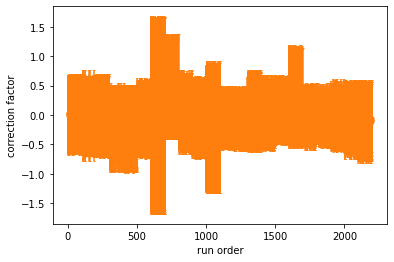

In [19]:
peaklist.batchCorrect(peaklist.sampleCols,[x for x in range(len(peaklist.sampleCols)) if "QC" in peaklist.sampleCols[x]],order.values)

In [21]:
if __name__ == "__main__":
    peaklist.removeRedundancy(0.9,0.5,-1,ms1ppm,numCores)

grouping peaks |██████████████████████████████████████████████████| 100.0% 2190 peak groups found
running mz.unity |██████████████████████████████████████████████████| 100.0% 
673 redundant features found


In [22]:
corrected_peak_areas = peaklist.peakList

Text(0, 0.5, 'metabolites')

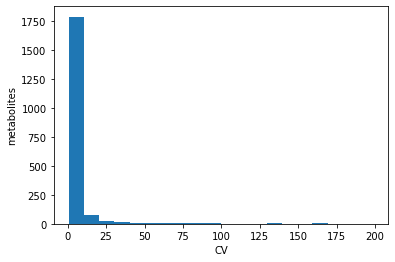

In [37]:
cvs = []
qcCols = [peaklist.sampleCols[x] for x in range(len(peaklist.sampleCols)) if "QC" in peaklist.sampleCols[x]]
for index,row in corrected_peak_areas.iterrows():
    s = np.std(np.power(2,row[qcCols].values))
    m = np.mean(np.power(2,row[qcCols].values))
    cvs.append(100*s/m)
plt.hist(cvs,bins=20)
plt.xlabel("CV")
plt.ylabel("metabolites")

In [38]:
corrected_peak_areas.to_csv(mzMLDir + "corrrected_peak_areas.csv")

Text(0, 0.5, 'metabolites')

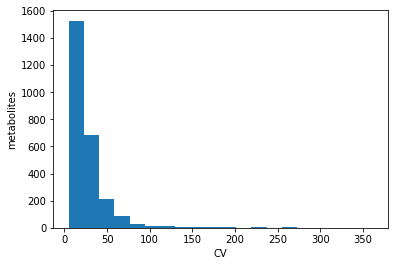

In [42]:
cvs = []
qcCols = [peaklist.sampleCols[x] for x in range(len(peaklist.sampleCols)) if "QC" in peaklist.sampleCols[x]]
for index,row in peak_areas.iterrows():
    s = np.std(row[qcCols].values)
    m = np.mean(row[qcCols].values)
    cvs.append(100*s/m)
plt.hist(cvs,bins=20)
plt.xlabel("CV")
plt.ylabel("metabolites")